In [1]:
%run ../nn_option_pricer/_key_imports.py
%run ../nn_option_pricer/nn_archi.py
%run ../nn_option_pricer/bachelier.py

In [2]:
from numpy.linalg import cholesky
from jax import grad
from jax.numpy import vectorize
from tqdm import tqdm

N_ASSETS = 100
F = N_ASSETS
N_SAMPLES = 10**4
T = 1.0
K = 1.0

# create a covariance matrix
rng = default_rng(42)
L = 0.2 * rng.standard_normal((N_ASSETS, F))
cov = L @ L.T
assert np.linalg.det(cov) > 0
L = cholesky(cov)
w = np.ones((N_ASSETS)) / N_ASSETS


params = {
    "N_SAMPLES":N_SAMPLES,
    "N_ASSETS": N_ASSETS,
    "F": F,
    "SEED": 42,
    "T1": (30/250),
    "T": 1.0,
    "K": 1.0,
    "S0": 1.0,
    "L": L,
    "w": w
}

for i, x in enumerate([(2022, "train"), (2023, "test")]):
    seed, name = x
    start = time.time()
    params2 = params.copy()
    params2["SEED"] = seed
    X_df, WT, St = make_bachelier_dataset(**params2)
    gen_time = time.time() - start

    ## The same evaluation, if we were to use Monte-Carlo
    start = time.time()
    payoff_MC = np.zeros((N_SAMPLES))
    grad_MC = np.zeros((N_SAMPLES))
    for i in tqdm(range(N_SAMPLES)):
        payoff_MC[i] = np.mean(payoff(abm_step(St[[i], :], WT, w), params["K"]))
        grad_MC[i] = grad(lambda x, WT, w: np.mean(payoff(abm_step(x, WT, w), params["K"])))(
            St[[i], :], WT, w
        )[:, 0]

    X_df["delta_MC"] = grad_MC
    X_df["call_MC"] = payoff_MC
    MC_time = time.time() - start
    
    
    X_df.to_csv(f"datasets/bachelier_{name}.csv", index=False)
    
    print(f"Required {gen_time} for {params['N_SAMPLES']} samples of {params['N_ASSETS']} assets")
    print(f"MC_Time required {MC_time}")
    


100%|█████████████████████████████████████| 10000/10000 [02:17<00:00, 72.84it/s]


Required -1656665560.882551 for 10000 samples of 100 assets
MC_Time required 137.28730082511902


100%|█████████████████████████████████████| 10000/10000 [03:12<00:00, 51.89it/s]


Required -1656665763.4427562 for 10000 samples of 100 assets
MC_Time required 192.71958088874817


## Evaluate Dataset Quality

In [3]:
sigma = np.sqrt(w @ L @ L.T @ w.T)
print(np.std(X_df["basket"]) / np.sqrt(params["T1"]), sigma)

0.20467512101717494 0.20455183160065224


In [4]:
X_df_train = pd.read_csv("datasets/bachelier_train.csv")

In [7]:
X_df_

,asset_0,asset_1,asset_2,asset_3,asset_4,asset_5,asset_6,asset_7,asset_8,asset_9,...,grad_asset99,call_payoff,basket,call_analytic,call_analytic_theta,call_analytic_vega,call_analytic_delta,call_analytic_gamma,delta_MC,call_MC
0,1.322843,1.812732,0.048256,1.114297,0.215693,1.444769,0.605145,-0.108603,0.382279,0.783435,...,0.0,0.000000,0.903803,0.042367,0.036531,0.357178,0.319077,1.746149,0.003210,0.041381
1,0.383369,0.773592,-0.316503,0.583982,1.408143,2.197312,0.832302,1.003334,1.788369,1.426154,...,0.01,0.014732,1.018261,0.091060,0.040640,0.397356,0.535568,1.942567,0.005387,0.090341
2,1.164639,0.429937,0.572834,2.280684,2.091036,1.613150,0.842448,1.610974,2.325876,0.087183,...,0.0,0.000000,1.084053,0.130425,0.037499,0.366644,0.659432,1.792426,0.006642,0.130030
3,-0.245380,-0.414793,0.406377,0.035683,0.805080,0.546831,1.468603,1.369671,0.958890,2.130487,...,0.0,0.000000,0.908282,0.043814,0.036900,0.360789,0.326938,1.763802,0.003303,0.042837
4,0.444030,1.672842,1.131673,0.566714,2.604997,1.355915,1.553727,0.706959,0.804681,1.100727,...,0.01,0.103210,1.087180,0.132496,0.037260,0.364305,0.665020,1.780993,0.006698,0.132117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.444886,1.867845,1.038600,0.348218,1.113943,1.070542,1.152774,0.338115,0.693815,2.208570,...,0.0,0.000000,0.972591,0.068631,0.040438,0.395377,0.446703,1.932893,0.004488,0.067833
9996,0.218417,0.209775,0.637498,0.449415,1.852394,-0.947881,1.759804,1.699587,1.685679,1.485942,...,0.01,0.084882,0.882019,0.035824,0.034550,0.337809,0.282045,1.651461,0.002836,0.034803
9997,0.379522,1.411034,0.518305,1.288143,1.389630,1.511248,0.825128,0.278865,1.602591,-0.323653,...,0.01,0.161069,0.926329,0.050005,0.038240,0.373889,0.359364,1.827846,0.003642,0.049106
9998,0.710410,2.412464,-0.280389,2.619251,-0.412712,0.583975,0.751513,1.847268,2.430745,1.051196,...,0.0,0.000000,1.045206,0.106192,0.039818,0.389318,0.587454,1.903272,0.005936,0.105600


0.4986


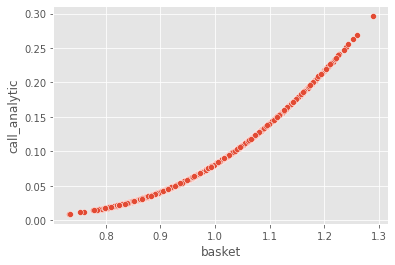

In [5]:
sns.scatterplot(X_df["basket"], X_df["call_analytic"])
intrinsic_val = np.maximum(X_df["basket"] - 1.0, 0)
print(np.mean(intrinsic_val > 0))

Text(0.5, 1.0, 'PDE error vs Strike')

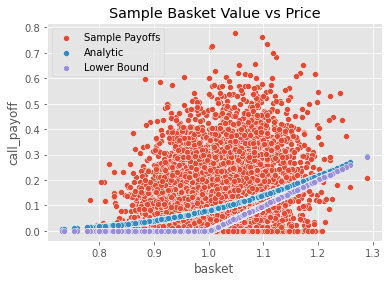

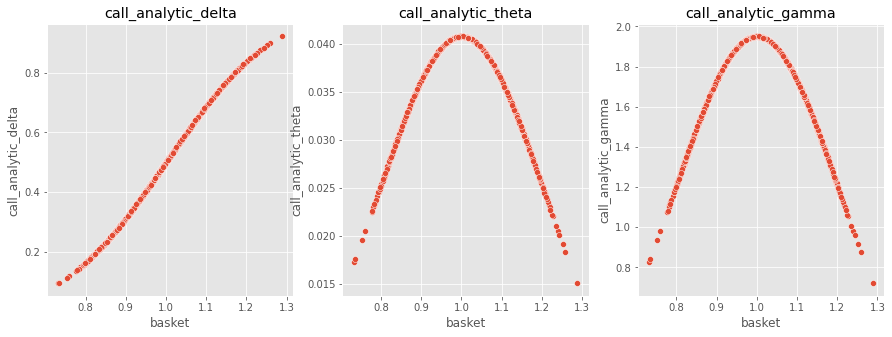

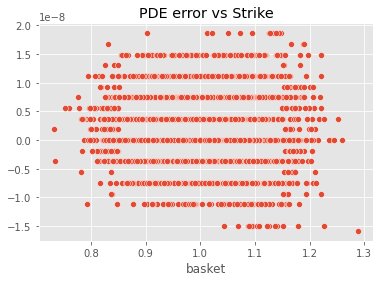

In [6]:
"""
Plot Price v Underlying
"""

fig, ax = plt.subplots()
sns.scatterplot(X_df["basket"], X_df["call_payoff"], ax=ax, label="Sample Payoffs")
sns.scatterplot(X_df["basket"], X_df["call_analytic"], ax=ax, label="Analytic")
sns.scatterplot(
    X_df["basket"], np.maximum(X_df["basket"] - K, 0), label="Lower Bound", ax=ax
)
ax.legend()
ax.set_title("Sample Basket Value vs Price")

"""
Plot Greeks
"""
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, x in enumerate(
    ["call_analytic_delta", "call_analytic_theta", "call_analytic_gamma"]
):
    sns.scatterplot(X_df["basket"], X_df[x], ax=ax[i])
    ax[i].set_title(x)

"""
PDE Err
"""
fig, ax = plt.subplots()
PDE_err = (
    -X_df["call_analytic_theta"] + 0.5 * (sigma**2) * X_df["call_analytic_gamma"]
)
sns.scatterplot(X_df["basket"], PDE_err)
ax.set_title("PDE error vs Strike")